#**Predictions of Sales**
**Creator: Ismaa-eel Hendricks**

# **Loading the Liabaries and the Data**

##**Libaries**

In [ ]:
#Week1 and 2
import pandas as pd
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


from sklearn import set_config
set_config(transform_output='pandas')
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

## **Functions**

Allows for settings of graphs to be plotted accordingly


### **Univariate EDA Functions**

In [ ]:
# UNIVARIATE PLOTTING FUNCTIONS FOR EDA
def explore_categorical(df, x, fillna = True, placeholder = 'MISSING',
                        figsize = (6,4), order = None):
  """Creates a seaborn countplot with the option to temporarily fill missing values
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  Source:https://github.com/coding-dojo-data-science/machine-learning-practice-solutions/blob/main/STARTER_Feature_Inspection.ipynb
         https://login.codingdojo.com/m/717/16237/120171

  """
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # Before filling nulls, save null value counts and percent for printing
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  # Create figure with desired figsize
  fig, ax = plt.subplots(figsize=figsize)
  # Plotting a count plot
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  # Rotate Tick Labels for long names
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  # Add a title with the feature name included
  ax.set_title(f"Column: {x}", fontweight='bold')

  # Fix layout and show plot (before print statements)
  fig.tight_layout()
  plt.show()

  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")

  # First find value counts of feature

  val_counts = temp_df[x].value_counts(dropna=False)
  # Define the most common value
  most_common_val = val_counts.index[0]
  # Define the frequency of the most common value
  freq = val_counts.values[0]
  # Calculate the percentage of the most common value
  perc_most_common = freq / len(temp_df) * 100


  # Print the results
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax


def explore_numeric(df, x, figsize=(6,5) ):
  """Creates a seaborn histplot and boxplot with a share x-axis,
  Prints statements about null values, cardinality, and checks for
  constant/quasi-constant features.
  Source:https://github.com/coding-dojo-data-science/machine-learning-practice-solutions/blob/main/STARTER_Feature_Inspection.ipynb
         https://login.codingdojo.com/m/717/16237/120173
  """

  ## Save null value counts and percent for printing
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100


  ## Making our figure with gridspec for subplots
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,
                           sharex=True, gridspec_kw=gridspec)
  # Histogram on Top
  sns.histplot(data=df, x=x, ax=axes[0])

  # Boxplot on Bottom
  sns.boxplot(data=df, x=x, ax=axes[1])

  ## Adding a title
  axes[0].set_title(f"Column: {x}", fontweight='bold')

  ## Adjusting subplots to best fill Figure
  fig.tight_layout()

  # Ensure plot is shown before message
  plt.show()


  # Print null value info
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  # Print cardinality info
  nunique = df[x].nunique()
  print(f"- Unique Values: {nunique}")


  # Get the most most common value, its count as # and as %
  most_common_val_count = df[x].value_counts(dropna=False).head(1)
  most_common_val = most_common_val_count.index[0]
  freq = most_common_val_count.values[0]
  perc_most_common = freq / len(df) * 100

  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")

  # print message if quasi-constant or constant (most common val more than 98% of data)
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, axes

### **Multivariate Feature vs. Target Functions.**

In [ ]:
"""MULTIVARIATE PLOTTING FUNCTIONS VS. NUMERIC TARGET"""

def plot_categorical_vs_target(df, x, y='Item_Outlet_Sales',figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None):
  """Plots a combination of a seaborn barplot of means combined with
  a seaborn stripplot to show the spread of the data.
  Source: https://github.com/coding-dojo-data-science/machine-learning-practice-solutions/blob/main/STARTER_Feature_Inspection.ipynb
          https://login.codingdojo.com/m/717/16237/120172
  """
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)

  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)

    # Barplot
  sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
              linewidth=1, edgecolor='black', errorbar=None)

  # Boxplot
  sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                order=order, hue_order=order, legend=False,
                edgecolor='white', linewidth=0.5,
                size=3,zorder=0)
  # Rotate xlabels
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

  # Add a title
  ax.set_title(f"{x} vs. {y}", fontweight='bold')
  fig.tight_layout()
  return fig, ax


def plot_numeric_vs_target(df, x, y='Item_Outlet_Sales',
                           figsize=(6,4)):
  """Plots a seaborn regplot with Pearson's correlation (r) added
  to the title.
  Source:https://github.com/coding-dojo-data-science/machine-learning-practice-solutions/blob/main/STARTER_Feature_Inspection.ipynb
         https://login.codingdojo.com/m/717/16237/120173
  """
  # Calculate the correlation
  corr = df[[x,y]].corr().round(2)
  r = corr.loc[x,y]

  # Plot the data
  fig, ax = plt.subplots(figsize=figsize)
  scatter_kws={'ec':'white','lw':1,'alpha':0.8}
  sns.regplot(data=df, x=x, y=y, ax=ax, scatter_kws=scatter_kws)

  ## Add the title with the correlation
  ax.set_title(f"{x} vs. {y} (r = {r})", fontweight='bold')

  # Make sure the plot is shown before the print statement
  plt.show()

  return fig, ax

### **CRISP-DM Phase 4 - Modeling**

In [ ]:
def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  # Get metrics
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    # Print Result with Label and Header
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics

def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False):
  # Get predictions for training data
  y_train_pred = reg.predict(X_train)

  # Call the helper function to obtain regression metrics for training data
  results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = reg.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )

  # Store results in a dataframe if ouput_frame is True
  if output_frame:
    results_df = pd.DataFrame([results_train,results_test])
    # Set the label as the index
    results_df = results_df.set_index('Label')
    # Set index.name to none to get a cleaner looking result
    results_df.index.name=None
    # Return the dataframe
    return results_df.round(3)

##**Data**
Uploading of the data set, to be used.

**Data Dictionary**

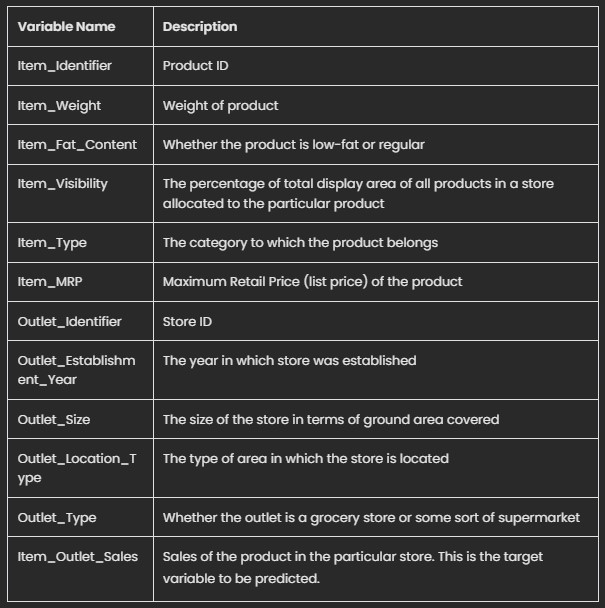

In [ ]:
#map the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#map the data
fpath = '/content/drive/MyDrive/week 2 data folder/core project part 2/sales_predictions_2023.csv'
df = pd.read_csv(fpath)

Duplicate Original Data set for safe keepingg

In [ ]:
#duplicate data
df2 = df.copy()

In [ ]:
#Explore the data
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


# **Data Cleaning**  **$(Week^2$)**

**Explore the data - What do you need to do to clean this data?**
**Clean it!**

Be sure to address each of the following tasks:

1) How many rows and columns?

2) What are the datatypes of each variable?

3) Are there duplicates? If so, drop any duplicates.

4) Identify missing values.

5) Address the missing values by using a placeholder value.

6) Confirm that there are no missing values after addressing them.

7) Find and fix any inconsistent categories of data (for example: fix cat, Cat, and cats so that they are consistent).

8) For any numerical columns, obtain the summary statistics of each (min, max, mean).

In [ ]:
#Explore the data
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


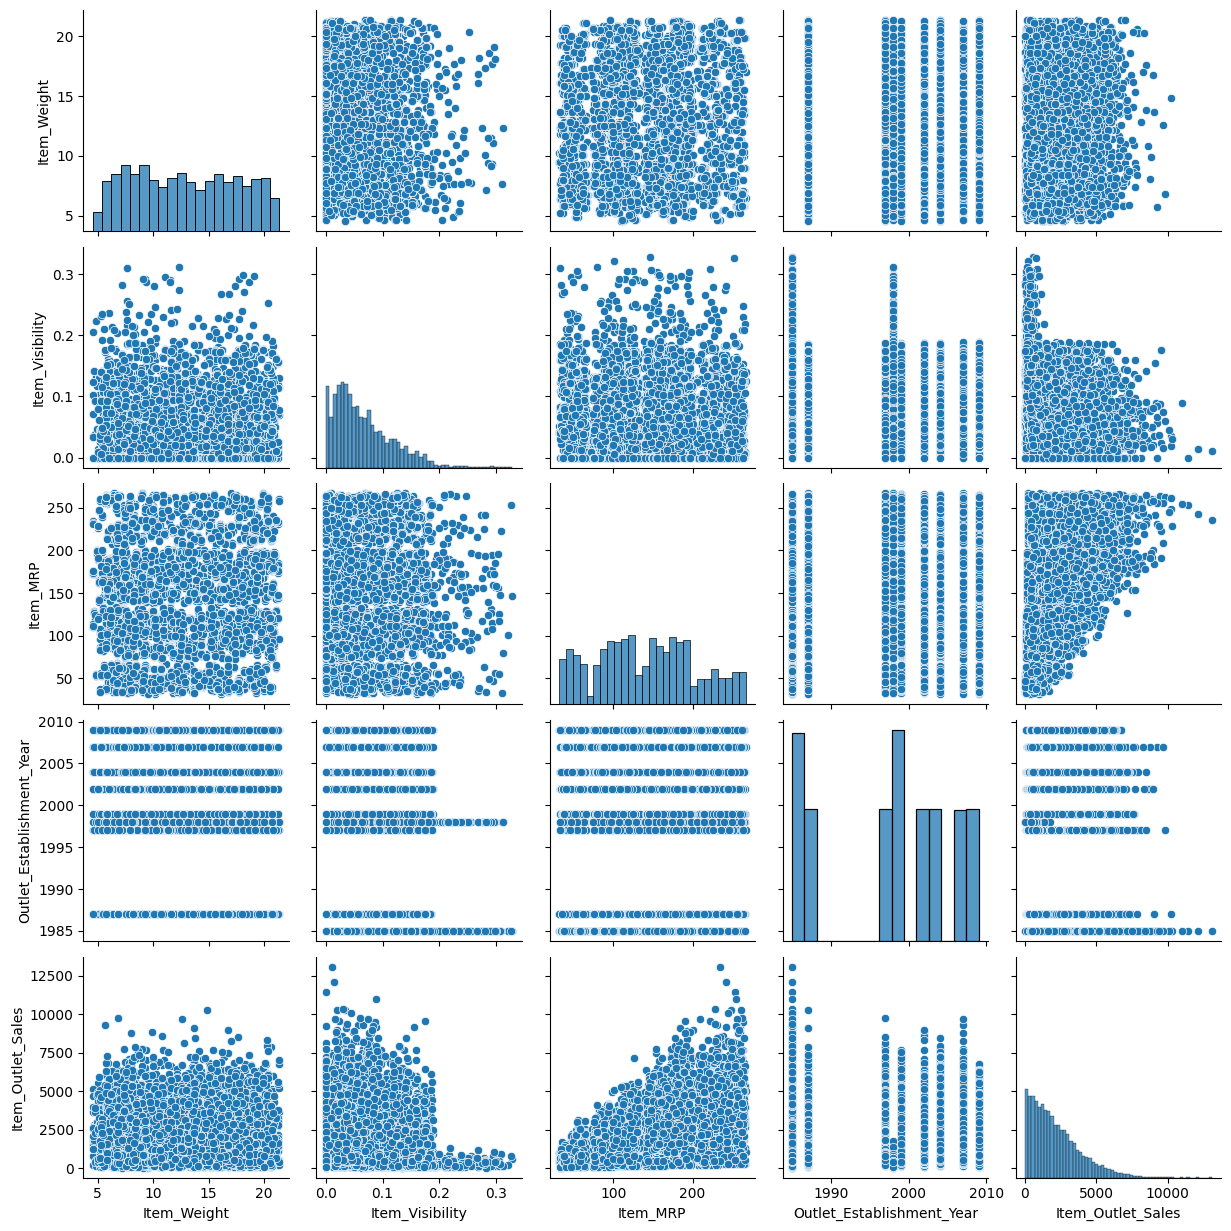

In [ ]:
sns.pairplot(df[1:])

In [ ]:
#1) How many rows and columns?
df.shape


(8523, 12)

In [ ]:
#2) What are the datatypes of each variable?
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [ ]:
#Remove Outlet_Identifier column as this does not have any use in the data set
df = df.drop(['Outlet_Identifier','Item_Identifier'], axis=1)

In [ ]:
#df['Outlet_Identifier'] = df['Outlet_Identifier'].str.replace('OUT', '')
#df['Outlet_Identifier'].value_counts()

In [ ]:
#df['Outlet_Identifier'] = df['Outlet_Identifier'].astype(int)
#df['Outlet_Identifier'].dtypes

In [ ]:
#Converting Outlet_Location_Type column to int
#df['Outlet_Location_Type'].value_counts()

In [ ]:
#df['Outlet_Location_Type'] = df['Outlet_Location_Type'].str.replace('Tier ', '')
#df['Outlet_Location_Type'].value_counts()

In [ ]:
#df['Outlet_Location_Type'] = df['Outlet_Location_Type'].astype(int)
#df['Outlet_Location_Type'].dtypes

In [ ]:
#3) Are there duplicates? If so, drop any duplicates.
df.duplicated().sum()

0

There are no duplicates rows

In [ ]:
#4) Identify missing values.
df.isnull().sum()

Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

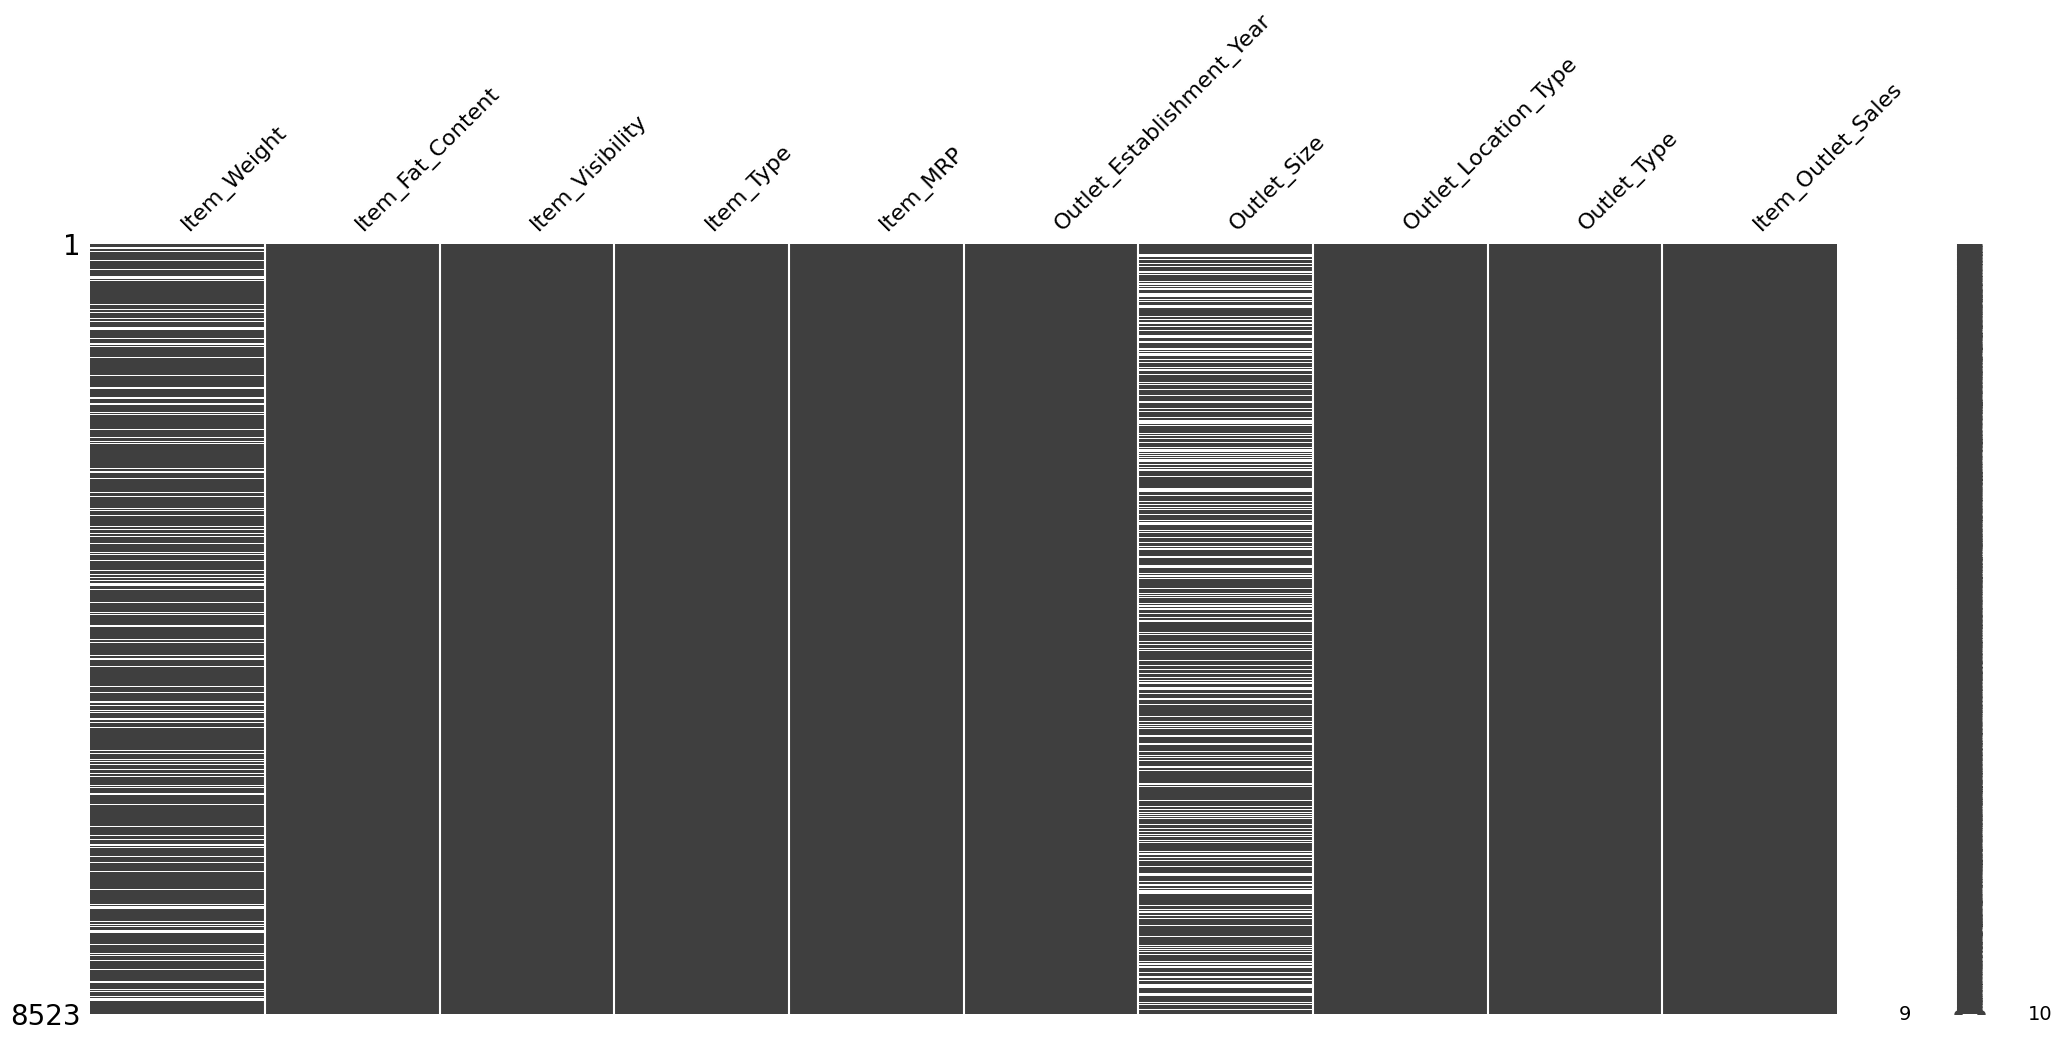

In [ ]:
msno.matrix(df);

In [ ]:
#5) Address the missing values by using a placeholder value.
#Item weight(why use the fill method?)
df['Item_Weight'] = df['Item_Weight'].fillna(-1)

In [ ]:
df['Outlet_Size'] = df['Outlet_Size'].fillna('MISSING')

In [ ]:
#6) Confirm that there are no missing values after addressing them.
df.isnull().sum()

Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

Outlet Location Type and Outlet Identifier can be converted to numeric datatypes

In [ ]:
#7) Find and fix any inconsistent categories of data (for example: fix cat, Cat, and cats so that they are consistent).
obj_columns = df.select_dtypes('object').columns
obj_columns

Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type'],
      dtype='object')

In [ ]:
#Excluding Item_Identifier as that should be the indexing column
obj_columns = obj_columns[1:]
obj_columns

Index(['Item_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'], dtype='object')

In [ ]:
df[obj_columns].nunique()

Item_Type               16
Outlet_Size              4
Outlet_Location_Type     3
Outlet_Type              4
dtype: int64

In [ ]:
#Check value counts and correct inconsistencies
# loop through the list of string columns
for i in obj_columns:
  # print the value counts for the column
  print(f"{i}:")
  print(df[i].value_counts())
  # Print an empty line for readability
  print ('\n')

Item_Type:
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


Outlet_Size:
Medium     2793
MISSING    2410
Small      2388
High        932
Name: Outlet_Size, dtype: int64


Outlet_Location_Type:
Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64


Outlet_Type:
Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64




In [ ]:
#based on the above info, Item_Fat_Content in the has inconcistencies of data
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [ ]:
#change Lf to low fat and reg with regular
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF': 'Low Fat','low fat': 'Low Fat', 'reg': 'Regular'})

In [ ]:
# outlet type also has inconcistanceis
# Grocery Store converted to supermarket type4
df['Outlet_Type'].value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

In [ ]:
df['Outlet_Type'] = df['Outlet_Type'].str.replace('Grocery Store','Supermarket Type4')
df['Outlet_Type'].value_counts()

Supermarket Type1    5577
Supermarket Type4    1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

In [ ]:
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [ ]:
#call all columns that are numeri
num_columns = df.select_dtypes('number').columns
print(num_columns)

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales'],
      dtype='object')


In [ ]:
#8) For any numerical columns, obtain the summary statistics of each (min, max, mean).

In [ ]:
for i in num_columns:
  print(f"{i}")
  print(df[i].describe().loc[['min', 'max', 'mean']])
  print('\n')

Item_Weight
min     -1.000000
max     21.350000
mean    10.478936
Name: Item_Weight, dtype: float64


Item_Visibility
min     0.000000
max     0.328391
mean    0.066132
Name: Item_Visibility, dtype: float64


Item_MRP
min      31.290000
max     266.888400
mean    140.992782
Name: Item_MRP, dtype: float64


Outlet_Establishment_Year
min     1985.000000
max     2009.000000
mean    1997.831867
Name: Outlet_Establishment_Year, dtype: float64


Item_Outlet_Sales
min        33.290000
max     13086.964800
mean     2181.288914
Name: Item_Outlet_Sales, dtype: float64




# **Exploratory Data Viz**  **$(Week^3$)**

For Part 3, your task is to complete any statistical analyses that might help you understand, explain, or model with your data.

This must include at least one of each:

- Histograms to view the distributions of numerical features in your dataset.
- Boxplots to view statistical summaries of numerical features in your dataset.
- Countplots to view the frequency of each class of categorial features in your dataset.
- Heatmap to view the correlation between features.

##Identify the difference between Numerical and categorical features:

- Removed, Item_Identifier and 'Outlet_Identifier', as these are indexing columns

In [ ]:
df.dtypes

Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [ ]:
# Identify numerical features
numerical_features = []
for column in df.columns:
  if df[column].dtype.name != "object":
    numerical_features.append(column)

    # Identify categorical features
categorical_features = []
for column in df.columns:
  if df[column].dtype.name == "object":
    categorical_features.append(column)

    # Identify ordinal features
ordinal_features = []
for column in df.columns:
  if df[column].dtype.name == "category":
    ordinal_features.append(column)

# Print the numerical features
print("Numerical features:")
print(numerical_features)
print('\n')

# Print the categorical features
print("Categorical features:")
print(categorical_features)
print('\n')

# Print the ordinal features
print("Ordinal features:")
print(ordinal_features)


Numerical features:
['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year', 'Item_Outlet_Sales']


Categorical features:
['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']


Ordinal features:
[]


##**Statistical analyses (Numerical features)**
*- Histograms to view the distributions of numerical features in your dataset.*

*- Boxplots to view statistical summaries of numerical features in your dataset.*

Numerical features:
- 'Item_Weight'
- 'Item_Visibility'
- 'Item_MRP'
- 'Outlet_Establishment_Year'
- 'Item_Outlet_Sales

###Item Weight

In [ ]:
df['Item_Weight'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 8523 entries, 0 to 8522
Series name: Item_Weight
Non-Null Count  Dtype  
--------------  -----  
8523 non-null   float64
dtypes: float64(1)
memory usage: 66.7 KB


In [ ]:
df['Item_Weight'].value_counts()

-1.000     1463
 12.150      86
 17.600      82
 13.650      77
 11.800      76
           ... 
 7.275        2
 7.685        1
 9.420        1
 6.520        1
 5.400        1
Name: Item_Weight, Length: 416, dtype: int64

In [ ]:
df['Item_Weight'].describe()

count    8523.000000
mean       10.478936
std         6.720742
min        -1.000000
25%         6.650000
50%        11.000000
75%        16.000000
max        21.350000
Name: Item_Weight, dtype: float64

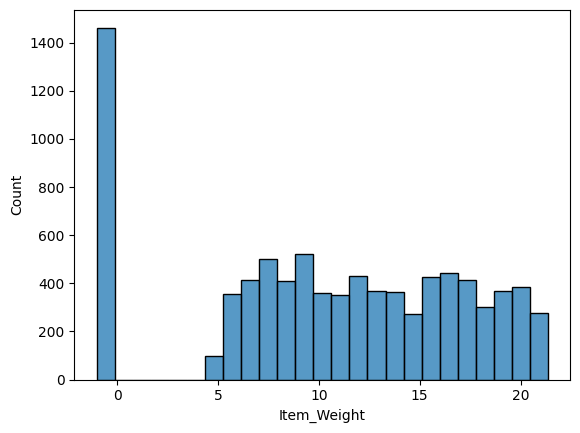

In [ ]:
ax = sns.histplot(data=df, x ='Item_Weight')

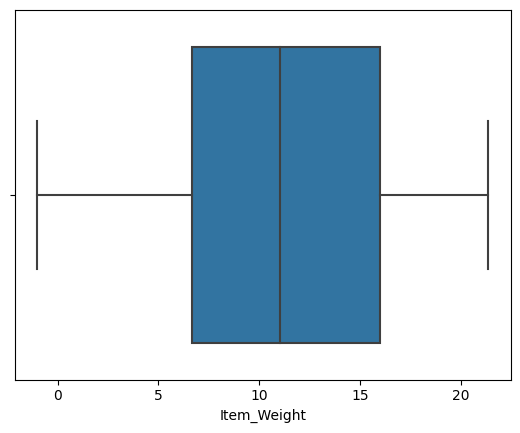

In [ ]:
ax = sns.boxplot(data = df, x = 'Item_Weight')

#####Interpertation:##
 - There is a 1463, items recorded where the Item_Weight was not provided
 - Due to the missing information, the data set will not show the true distribution accrosss all items
 - The information that has been provided we can deduce the items can weigh anytying between 5 and 22, units with the heaviest being 21.35 units

###Item Visibility

In [ ]:
df['Item_Visibility'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 8523 entries, 0 to 8522
Series name: Item_Visibility
Non-Null Count  Dtype  
--------------  -----  
8523 non-null   float64
dtypes: float64(1)
memory usage: 66.7 KB


In [ ]:
df['Item_Visibility'].value_counts()

0.000000    526
0.076975      3
0.162462      2
0.076841      2
0.073562      2
           ... 
0.013957      1
0.110460      1
0.124646      1
0.054142      1
0.044878      1
Name: Item_Visibility, Length: 7880, dtype: int64

In [ ]:
df['Item_Visibility'].describe()

count    8523.000000
mean        0.066132
std         0.051598
min         0.000000
25%         0.026989
50%         0.053931
75%         0.094585
max         0.328391
Name: Item_Visibility, dtype: float64

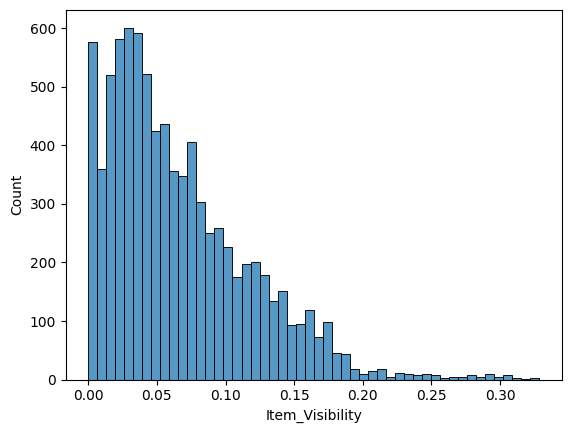

In [ ]:
ax = sns.histplot(data=df, x = 'Item_Visibility')

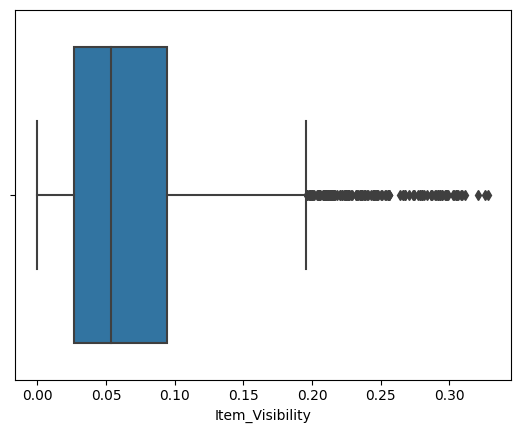

In [ ]:
ax = sns.boxplot(data = df, x = 'Item_Visibility')

**Interpratation:**

- Majority of the items have a visibaity of less then 10%
- Items under a 100 has the leaset visability

###Item MRP

In [ ]:
df['Item_MRP'].info()


<class 'pandas.core.series.Series'>
RangeIndex: 8523 entries, 0 to 8522
Series name: Item_MRP
Non-Null Count  Dtype  
--------------  -----  
8523 non-null   float64
dtypes: float64(1)
memory usage: 66.7 KB


In [ ]:
df['Item_MRP'].value_counts()

172.0422    7
170.5422    6
196.5084    6
188.1872    6
142.0154    6
           ..
97.3384     1
83.1934     1
96.6752     1
152.6682    1
75.4670     1
Name: Item_MRP, Length: 5938, dtype: int64

In [ ]:
df['Item_MRP'].describe()


count    8523.000000
mean      140.992782
std        62.275067
min        31.290000
25%        93.826500
50%       143.012800
75%       185.643700
max       266.888400
Name: Item_MRP, dtype: float64

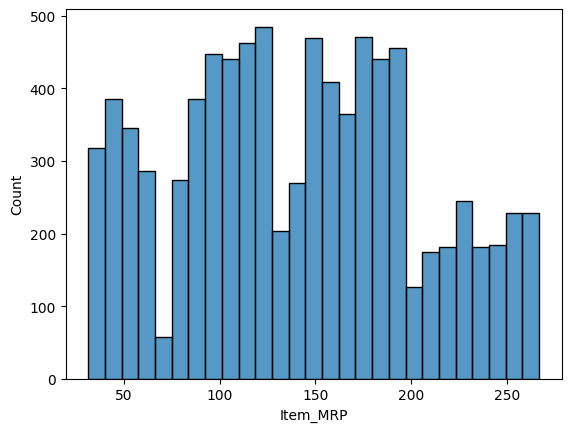

In [ ]:
ax = sns.histplot(data = df, x ='Item_MRP')

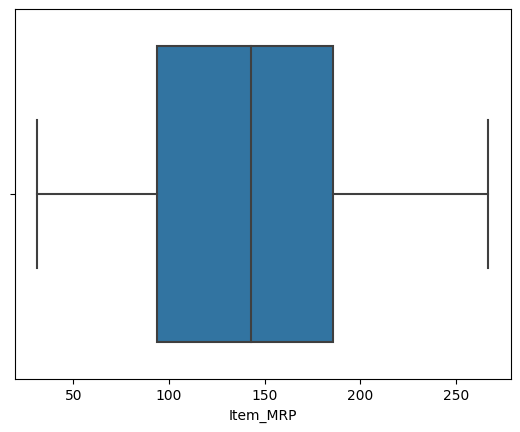

In [ ]:
ax = sns.boxplot(data = df, x = 'Item_MRP')

**Interpretation:**
-
-
-

###Outlet_Establishment_Year

In [ ]:
df['Outlet_Establishment_Year'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 8523 entries, 0 to 8522
Series name: Outlet_Establishment_Year
Non-Null Count  Dtype
--------------  -----
8523 non-null   int64
dtypes: int64(1)
memory usage: 66.7 KB


In [ ]:
df['Outlet_Establishment_Year'].value_counts()

1985    1463
1987     932
1999     930
1997     930
2004     930
2002     929
2009     928
2007     926
1998     555
Name: Outlet_Establishment_Year, dtype: int64

In [ ]:
df['Outlet_Establishment_Year'].describe()

count    8523.000000
mean     1997.831867
std         8.371760
min      1985.000000
25%      1987.000000
50%      1999.000000
75%      2004.000000
max      2009.000000
Name: Outlet_Establishment_Year, dtype: float64

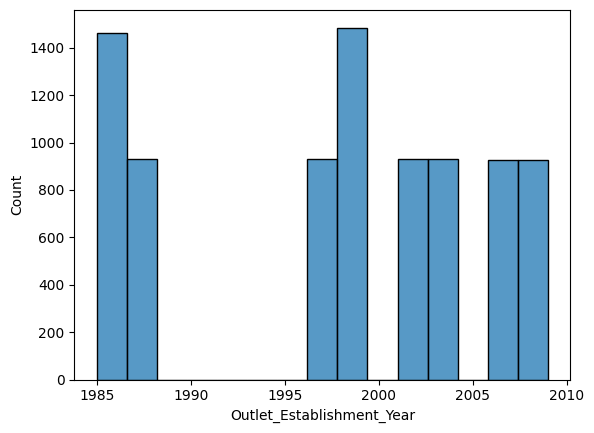

In [ ]:
ax = sns.histplot(data=df, x ='Outlet_Establishment_Year')

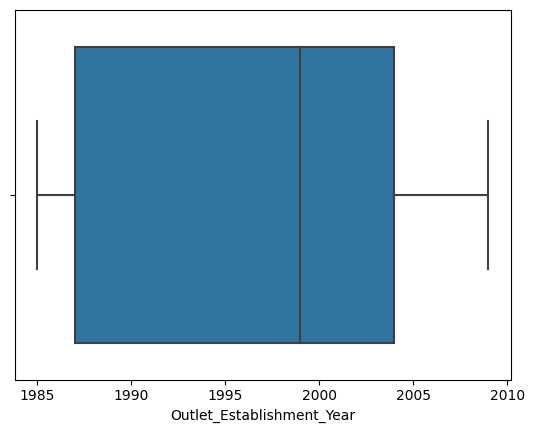

In [ ]:
ax = sns.boxplot(data = df, x = 'Outlet_Establishment_Year')

#####Interpertation:##
 - There was a boom in stores being established between 1985 and 1989 then was slience between 1990 and 1996
 - medadian of stores was establihshed between 1997 and 2008.

###Item_Outlet_Sales

In [ ]:
df['Item_Outlet_Sales'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 8523 entries, 0 to 8522
Series name: Item_Outlet_Sales
Non-Null Count  Dtype  
--------------  -----  
8523 non-null   float64
dtypes: float64(1)
memory usage: 66.7 KB


In [ ]:
df['Item_Outlet_Sales'].value_counts()

958.7520     17
1342.2528    16
703.0848     15
1845.5976    15
1278.3360    14
             ..
4124.6310     1
6622.7126     1
1614.5650     1
5602.7070     1
2778.3834     1
Name: Item_Outlet_Sales, Length: 3493, dtype: int64

In [ ]:
df['Item_Outlet_Sales'].describe()

count     8523.000000
mean      2181.288914
std       1706.499616
min         33.290000
25%        834.247400
50%       1794.331000
75%       3101.296400
max      13086.964800
Name: Item_Outlet_Sales, dtype: float64

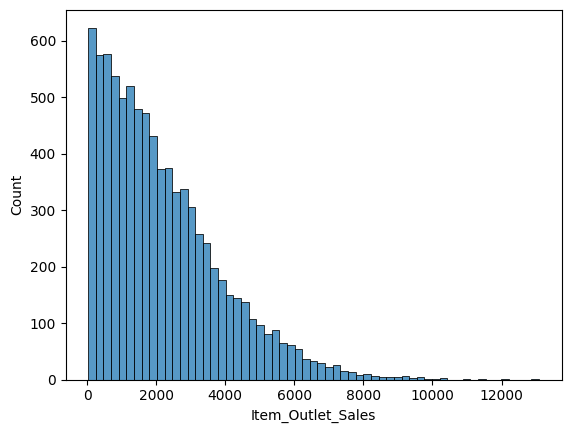

In [ ]:
ax = sns.histplot(data=df, x ='Item_Outlet_Sales')

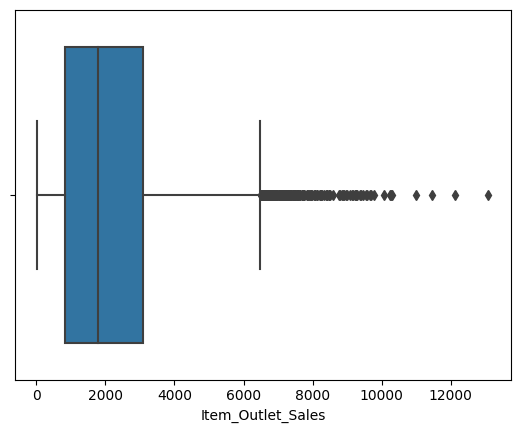

In [ ]:
ax = sns.boxplot(data = df, x = 'Item_Outlet_Sales')

#####Interpertation:##
 - There is a 1463, items recorded where the Item_Weight was not provided
 - Due to the missing information, the data set will not show the true distribution accrosss all items
 - The information that has been provided we can deduce the items can weigh anytying between 5 and 22, units with the heaviest being 21.35 units

##**Statistical analyses (Categorical Features)**
- Countplots to view the frequency of each class of categorial features in your dataset.

Categorical Features:
- Item_Identifier
- Item_Fat_Content
- Item_Type
- Outlet_Identifier ( cat to be reviewed)
- Outlet_Size
- Outlet_Type
- Outlet_Location_Type'

###Item_Fat_Content

In [ ]:
df['Item_Fat_Content'].info()


<class 'pandas.core.series.Series'>
RangeIndex: 8523 entries, 0 to 8522
Series name: Item_Fat_Content
Non-Null Count  Dtype 
--------------  ----- 
8523 non-null   object
dtypes: object(1)
memory usage: 66.7+ KB


In [ ]:
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [ ]:
df['Item_Fat_Content'].describe()

count        8523
unique          2
top       Low Fat
freq         5517
Name: Item_Fat_Content, dtype: object

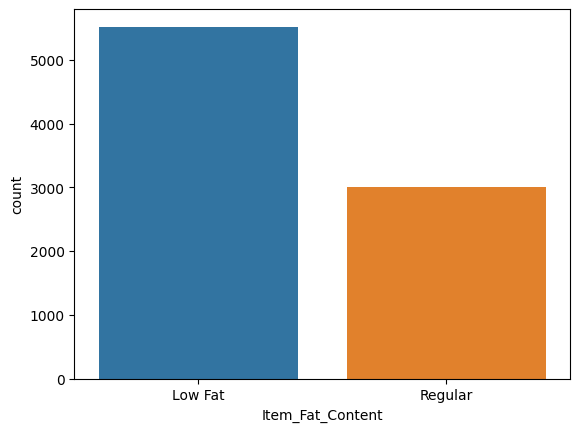

In [ ]:
ax = sns.countplot(data = df, x = 'Item_Fat_Content')

Interpretation:

-  Low fat items are greater in demarned then Regular fat items
- Twice the amount of low fat items are sold than Regular items

###Item_Type

In [ ]:
df['Item_Type'].info()


<class 'pandas.core.series.Series'>
RangeIndex: 8523 entries, 0 to 8522
Series name: Item_Type
Non-Null Count  Dtype 
--------------  ----- 
8523 non-null   object
dtypes: object(1)
memory usage: 66.7+ KB


In [ ]:
df['Item_Type'].value_counts()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

In [ ]:
df['Item_Type'].describe()

count                      8523
unique                       16
top       Fruits and Vegetables
freq                       1232
Name: Item_Type, dtype: object

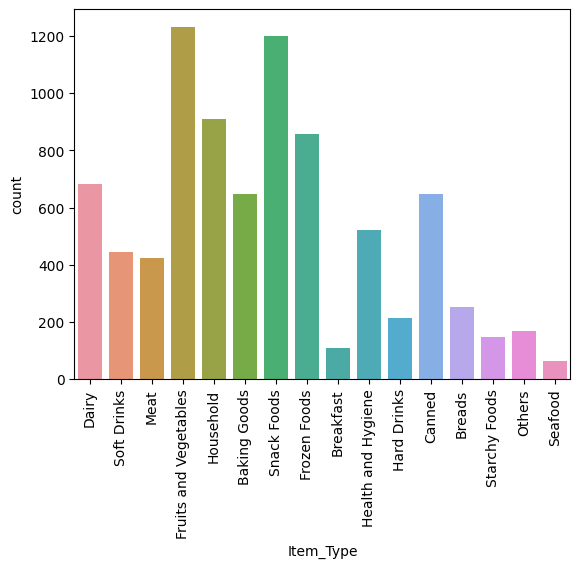

In [ ]:
ax = sns.countplot(data = df, x = 'Item_Type')
plt.setp(ax.get_xticklabels(), rotation=90);

Interpretation:

- Freshfood Items are greater in demarned then Confectionary Items
- Breakfast and Seafood Items are the items that are least sold

###Outlet_Size

In [ ]:
df['Outlet_Size'].info()


<class 'pandas.core.series.Series'>
RangeIndex: 8523 entries, 0 to 8522
Series name: Outlet_Size
Non-Null Count  Dtype 
--------------  ----- 
8523 non-null   object
dtypes: object(1)
memory usage: 66.7+ KB


In [ ]:
df['Outlet_Size'].value_counts()

Medium     2793
MISSING    2410
Small      2388
High        932
Name: Outlet_Size, dtype: int64

In [ ]:
df['Outlet_Size'].describe()

count       8523
unique         4
top       Medium
freq        2793
Name: Outlet_Size, dtype: object

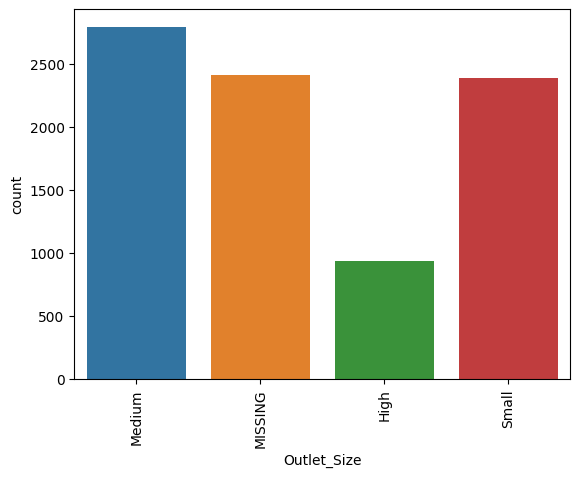

In [ ]:
ax = sns.countplot(data = df, x = 'Outlet_Size')
plt.setp(ax.get_xticklabels(), rotation=90);

Interpretation:

- There were just under 2500 entries in the dataset where the outlet size was missing
- Higest amount of items in the medium outlets (>2500)
- Only around 1000 items in the High category of outlets.

###Outlet_Type

In [ ]:
df['Outlet_Type'].info()


<class 'pandas.core.series.Series'>
RangeIndex: 8523 entries, 0 to 8522
Series name: Outlet_Type
Non-Null Count  Dtype 
--------------  ----- 
8523 non-null   object
dtypes: object(1)
memory usage: 66.7+ KB


In [ ]:
df['Outlet_Type'].value_counts()

Supermarket Type1    5577
Supermarket Type4    1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

In [ ]:
df['Outlet_Type'].describe()

count                  8523
unique                    4
top       Supermarket Type1
freq                   5577
Name: Outlet_Type, dtype: object

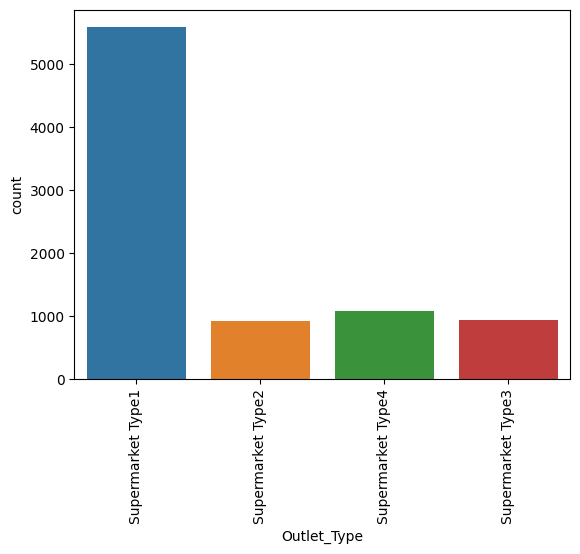

In [ ]:
ax = sns.countplot(data = df, x = 'Outlet_Type')
plt.setp(ax.get_xticklabels(), rotation=90);

Interpretation:

- Supermarket Type1 is preferable over the other store types.


###Outlet_Location_Type

In [ ]:
df['Outlet_Location_Type'].info()


<class 'pandas.core.series.Series'>
RangeIndex: 8523 entries, 0 to 8522
Series name: Outlet_Location_Type
Non-Null Count  Dtype 
--------------  ----- 
8523 non-null   object
dtypes: object(1)
memory usage: 66.7+ KB


In [ ]:
df['Outlet_Location_Type'].value_counts()

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

In [ ]:
df['Outlet_Location_Type'].describe()

count       8523
unique         3
top       Tier 3
freq        3350
Name: Outlet_Location_Type, dtype: object

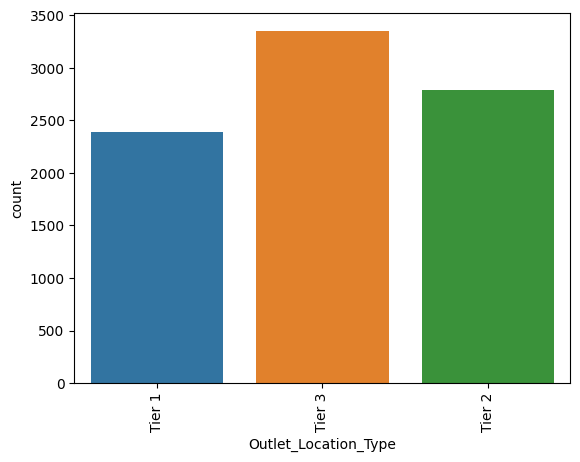

In [ ]:
ax = sns.countplot(data = df, x = 'Outlet_Location_Type')
plt.setp(ax.get_xticklabels(), rotation=90);

Interpretation:

Tier 3 is the preferrable locaton for stors with teir 2 and tier 1 been the least prefered location for stores.

##**Heatmap**
To view the correlation between features.

In [ ]:
#Create a correlation Heatmap:
#Step 1 Create the correlation table
corr_table = df.corr()
corr_table.round(2)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Item_Weight,1.00,-0.08,0.02,0.54,-0.06
Item_Visibility,-0.08,1.00,-0.00,-0.07,-0.13
Item_MRP,0.02,-0.00,1.00,0.01,0.57
Outlet_Establishment_Year,0.54,-0.07,0.01,1.00,-0.05
Item_Outlet_Sales,-0.06,-0.13,0.57,-0.05,1.00


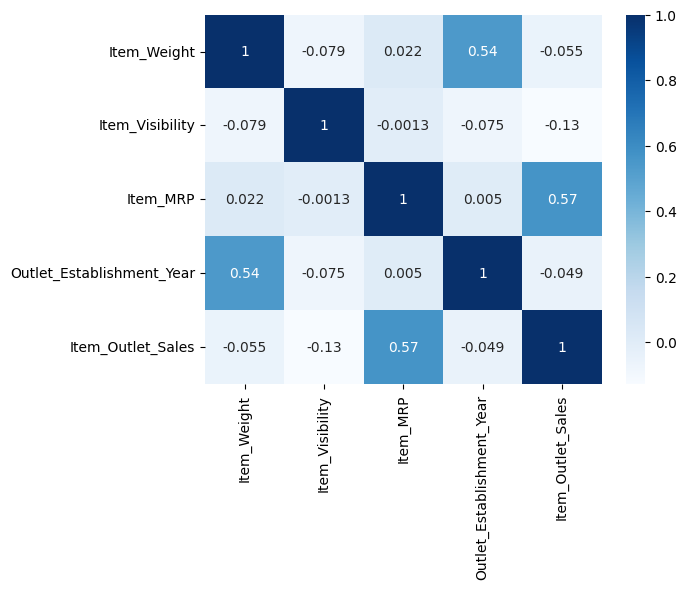

In [ ]:
#plot the correslationship table
ax = sns.heatmap(corr_table, cmap = 'Blues', annot = True)

Interpretation:
- There is a moderate positive correlation between Maximum retail price and item outlet sales (0.57)
- Moderate positive correlation between item weight and outlet establishment year (0.54)

# **Explanatory Data Viz $(Week^4)$**

**For Part 4, your task is to inspect the features:**  

We will continue to work on your sales prediction project. The goal of this is to help the retailer understand the properties of products and outlets that play crucial roles in increasing sales.

The target is ****Item_Outlet_Sales****.

For feature inspection, we want to be fully aware of any null values present so that we can make informed choices about data preparation for machine learning in the next course.


## Remove the placeholders you added in week 2 and replace them with null values.
This will allow our functions to report the presence and frequency of null values as part of our EDA.​

In [ ]:
# Load the original DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                8523 non-null   float64
 1   Item_Fat_Content           8523 non-null   object 
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Establishment_Year  8523 non-null   int64  
 6   Outlet_Size                8523 non-null   object 
 7   Outlet_Location_Type       8523 non-null   object 
 8   Outlet_Type                8523 non-null   object 
 9   Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 666.0+ KB


In [ ]:
#replace -1 with null values
df['Item_Weight'] = df['Item_Weight'].replace(-1, np.nan)

In [ ]:
#Replace Missing with no values(None)
df['Outlet_Size'] = df['Outlet_Size'].replace('MISSING', None)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                7060 non-null   float64
 1   Item_Fat_Content           8523 non-null   object 
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Establishment_Year  8523 non-null   int64  
 6   Outlet_Size                6113 non-null   object 
 7   Outlet_Location_Type       8523 non-null   object 
 8   Outlet_Type                8523 non-null   object 
 9   Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 666.0+ KB


In [ ]:
#confirm the null values and missing values have been replaced.
df.isnull().sum()

Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [ ]:
data_types = df.dtypes

numerical_features = []
for column in df.columns:
  if df[column].dtype.name != "object":
    numerical_features.append(column)

    # Identify categorical features
categorical_features = []
for column in df.columns:
  if df[column].dtype.name == "object":
    categorical_features.append(column)

    # Identify ordinal features
ordinal_features = []
for column in df.columns:
  if df[column].dtype.name == "object":
    if pd.api.types.is_categorical_dtype(df[column]):
      ordinal_features.append(column)

# Print the numerical features
print("Numerical features:")
print(numerical_features)
print('\n')

# Print the categorical features
print("Categorical features:")
print(categorical_features)
print('\n')

# Print the ordinal features
print("Ordinal features:")
print(ordinal_features)

Numerical features:
['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year', 'Item_Outlet_Sales']


Categorical features:
['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']


Ordinal features:
[]


## Numerical features:

### Feature: Item_Weight
**Target:** Item_Outlet_Sales

**Definition:** Weight of product

In [ ]:
#Create a univariate visualization showing the distribution of values/categories
#define the feature
feature = "Item_Weight"
df[feature].dtype

dtype('float64')

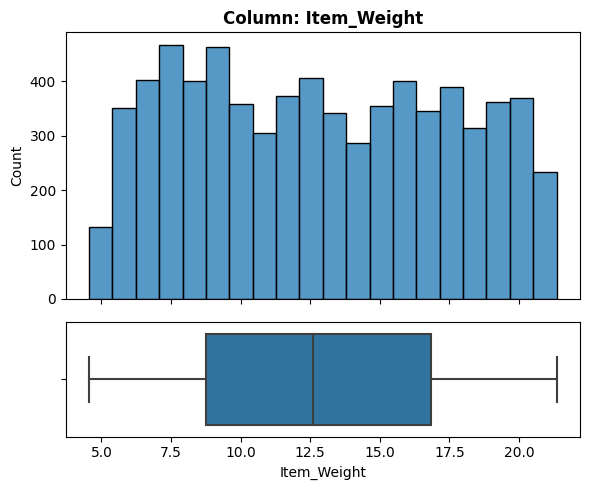

- NaN's Found: 1463 (17.17%)
- Unique Values: 415
- Most common value: 'nan' occurs 1463 times (17.17%)
- Not constant or quasi-constant.


In [ ]:
explore_numeric(df, feature);

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
    
    *Numerical feature*
2. How many null values?

    *NaN's Found: 1463*

3. What percentage?

(17.17%)

4. What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)

    As the column holds critcal information, it would be imputted with the mean

5. Is the feature constant or quasi-constant?
    Not constant or quasi-constant.

6. What is the cardinality? Is it high (>10)?
    Not applicable to numeric Features

7. Would we know this feature before the target is determined?
    Yes

8. Is there a business case/understanding reason to exclude based on our business case?
   
    No.


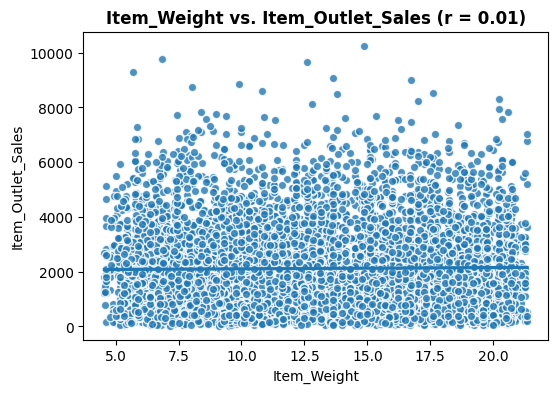

In [ ]:
#Create a multivariate visualization plotting each feature vs. the target.
plot_numeric_vs_target(df, feature);

1. Based on your business understanding, would you expect this feature to be a predictor of the target?

  Not really

2.  Does this feature appear to be a predictor of the target?
    
  No, there is no correlation between Item Weight and the target.


### Feature: Item_Visibility
**Target:** Item_Outlet_Sales

**Definition:** The percentage of total display area of all products in a store allocated to the particular product

In [ ]:
#Create a univariate visualization showing the distribution of values/categories
#define the feature
feature = "Item_Visibility"
df[feature].dtype

dtype('float64')

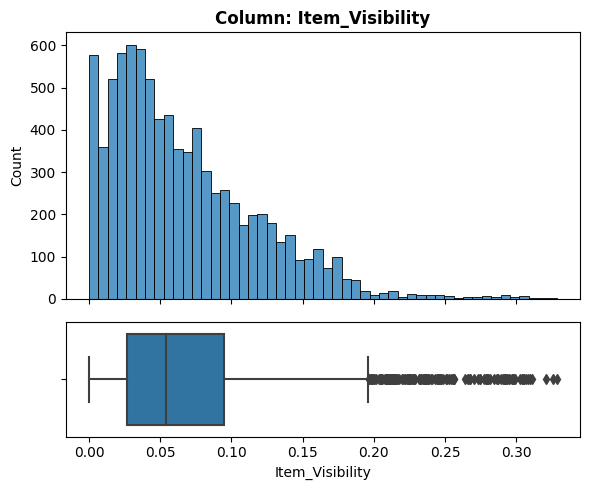

- NaN's Found: 0 (0.0%)
- Unique Values: 7880
- Most common value: '0.0' occurs 526 times (6.17%)
- Not constant or quasi-constant.


In [ ]:
explore_numeric(df, feature);

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)

    Numerical feature

2. How many null values?

    There are Zero null values

3. What percentage?

    0%

4. What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)\
    N/A, as this is numerical feature.
5. Is the feature constant or quasi-constant?

    Not constant or quasi-constant.

6. What is the cardinality? Is it high (>10)?

    Not applicable to numeric feature.

7. Would we know this feature before the target is determined?

    Yes
8. Is there a business case/understanding reason to exclude based on our business case?
    
    No


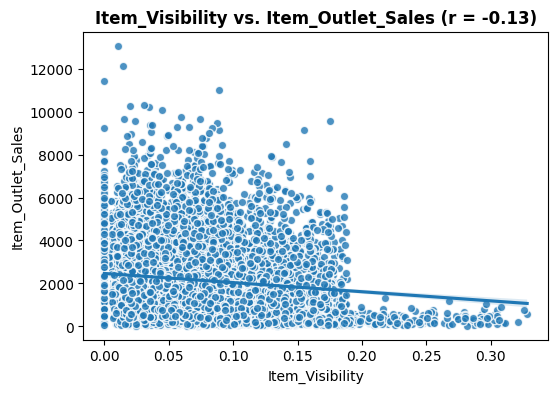

In [ ]:
#Create a multivariate visualization plotting each feature vs. the target.
plot_numeric_vs_target(df, feature);

1. Based on your business understanding, would you expect this feature to be a predictor of the target?

  Yes, it would.

2.  Does this feature appear to be a predictor of the target?

  Yes, there is a negative correlation(-0.13), between Item Visibility and Item Outlet Sales.

### Feature: Item_MRP
**Target:** Item_Outlet_Sales

**Definition:** Maximum Retail Price (list price) of the product

In [ ]:
#Create a univariate visualization showing the distribution of values/categories
#define the feature
feature = "Item_MRP"
df[feature].dtype

dtype('float64')

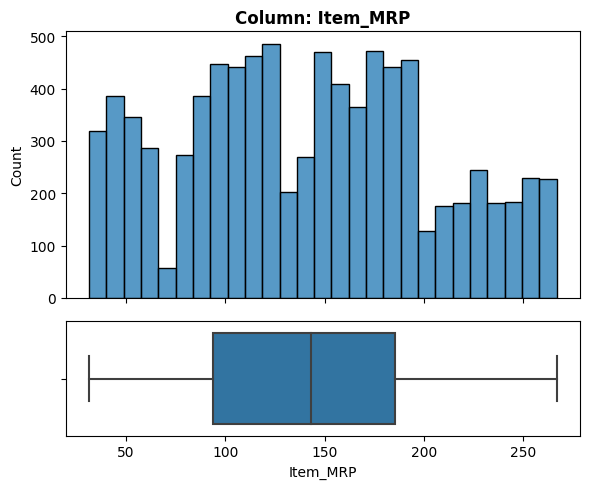

- NaN's Found: 0 (0.0%)
- Unique Values: 5938
- Most common value: '172.0422' occurs 7 times (0.08%)
- Not constant or quasi-constant.


In [ ]:
explore_numeric(df, feature);

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)

    Numeric.

2. How many null values?

    There are Zero null values.

3. What percentage?

    0%

4. What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)

    N/A, as this is numerical feature.

5.  Is the feature constant or quasi-constant?

    Not constant or quasi-constant.

6. What is the cardinality? Is it high (>10)?

    Not applicable to numeric feature.

7. Would we know this feature before the target is determined?
    Yes.

8. Is there a business case/understanding reason to exclude based on our business case?
    No.

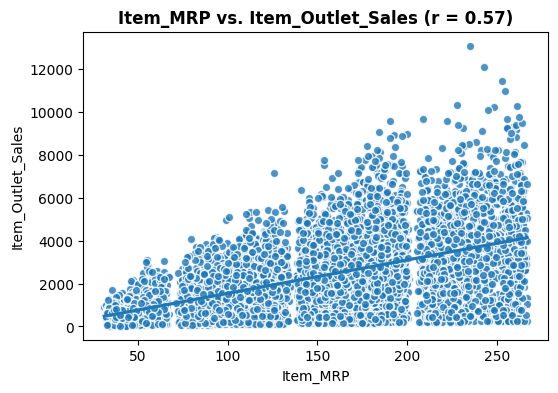

In [ ]:
#Create a multivariate visualization plotting each feature vs. the target.
plot_numeric_vs_target(df, feature);

1. Based on your business understanding, would you expect this feature to be a predictor of the target?

    Yes, this would be one of the leading predictors

2.  Does this feature appear to be a predictor of the target

    There is a postitive correlation between the Item MRP and Outlet sales.

### Feature: Outlet_Establishment_Year
**Target:** Item_Outlet_Sales

**Definition:** The year in which store was established

In [ ]:
#Create a univariate visualization showing the distribution of values/categories
#define the feature
feature = "Outlet_Establishment_Year"
df[feature].dtype

dtype('int64')

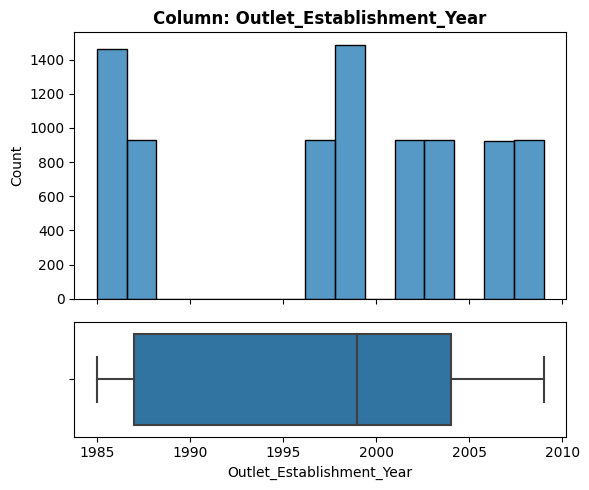

- NaN's Found: 0 (0.0%)
- Unique Values: 9
- Most common value: '1985' occurs 1463 times (17.17%)
- Not constant or quasi-constant.


In [ ]:
explore_numeric(df, feature);

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
    Nuemric
2. How many null values?
    Zero
3. What percentage?
    N/A
4. What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
    N/A

5. Is the feature constant or quasi-constant?
    Not constant or quasi-constant

6. What is the cardinality? Is it high (>10)?
    Not applicable to numeric feature

7. Would we know this feature before the target is determined?
    Yes

8. Is there a business case/understanding reason to exclude based on our business case?
    No.

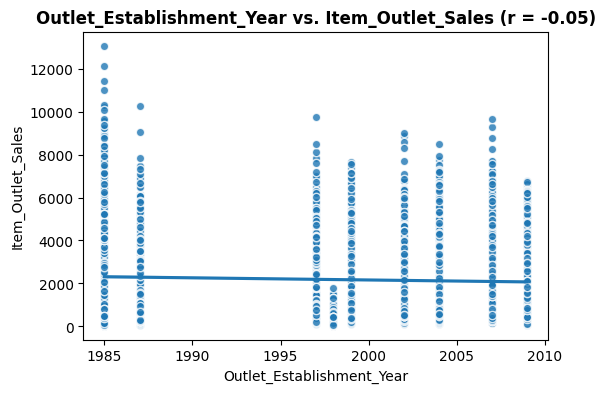

In [ ]:
#Create a multivariate visualization plotting each feature vs. the target.
plot_numeric_vs_target(df, feature);

1. Based on your business understanding, would you expect this feature to be a predictor of the target?

    It would be a supporting function that will, help.


2.  Does this feature appear to be a predictor of the target?
    No, there is no correlation between the two.
    

---------
---------

## Categorical features:
- Item_Identifier (Index column)
- Item_Fat_Content
- Item_Type
-  Outlet_Identifier (Index Column)
- Outlet_Size
- Outlet_Type
- Outlet_Location_Type

### Feature: Item_Fat_Content
**Target:** Item_Outlet_Sales

**Definition:** Whether the product is low-fat or regular


In [ ]:
#Create a univariate visualization showing the distribution of values/categories
#define the feature
feature = "Item_Fat_Content"
df[feature].dtype

dtype('O')

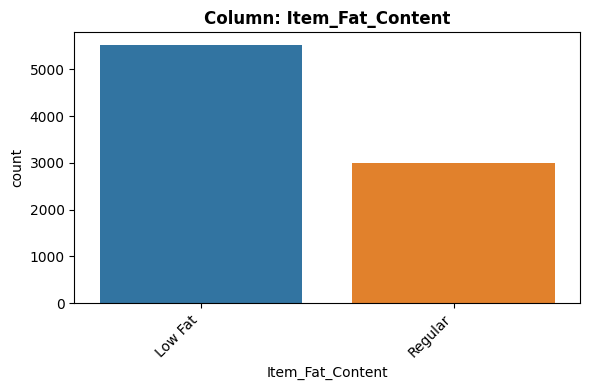

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: 'Low Fat' occurs 5517 times (64.73%)
- Not constant or quasi-constant.


In [ ]:
explore_categorical(df, feature);

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)

    Categorical (nominal)

2. How many null values?
    Null

3. What percentage?

    N/A

4. What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)

    N/A

5. Is the feature constant or quasi-constant?

    Not constant or quasi-constant

6. What is the cardinality? Is it high (>10)?
    Vey low, (2 Unique Values)

7. Would we know this feature before the target is determined?

    Yes.

8. Is there a business case/understanding reason to exclude based on our business case?,

    No.


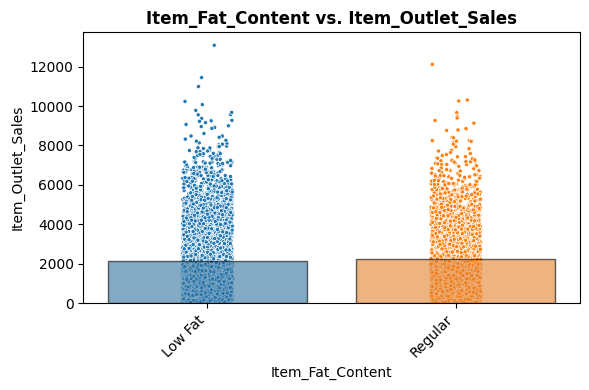

In [ ]:
# Run the appropriate feature vs. target function (based on dtype)
plot_categorical_vs_target(df, feature);

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
    Yes, will have a an ifluence

2.  Does this feature appear to be a predictor of the target?

    Yes, the values are spread quit evenly across the 2 categories.

### Feature: Item_Type
**Target:** Item_Outlet_Sales

**Definition:** The category to which the product belongs

In [ ]:
#Create a univariate visualization showing the distribution of values/categories
#define the feature
feature = "Item_Type"
df[feature].dtype

dtype('O')

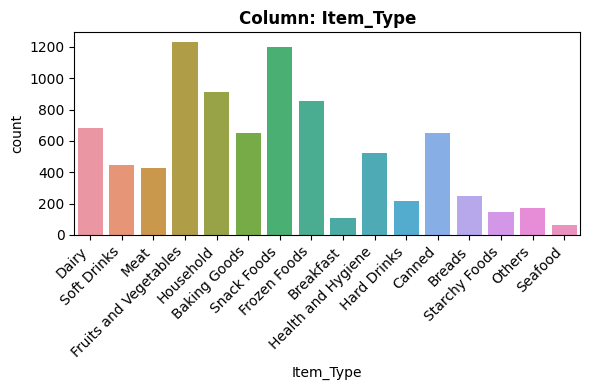

- NaN's Found: 0 (0.0%)
- Unique Values: 16
- Most common value: 'Fruits and Vegetables' occurs 1232 times (14.46%)
- Not constant or quasi-constant.


In [ ]:
explore_categorical(df, feature);

1. What type of feature is it? (Categorical (nominal),
ordinal, numeric)
    Categorical (nominal),


2. How many null values?

    N/A

3. What percentage?
    Zero
4. What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
    N/A
5. Is the feature constant or quasi-constant?
    Not constant or quasi-constant.
6. What is the cardinality? Is it high (>10)?
    It is high as it is greater than 10

7. Would we know this feature before the target is determined?
    Yes
8. Is there a business case/understanding reason to exclude based on our business case?
    
    No, this is one of the most important features.

In [ ]:
unique_values = set(df['Item_Type'])
cardinality = len(unique_values)
print(cardinality)

df['Item_Type'].count()

16


8523

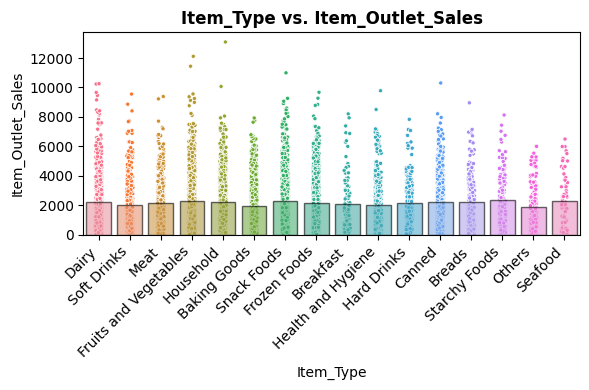

In [ ]:
# Run the appropriate feature vs. target function (based on dtype)
plot_categorical_vs_target(df, feature);

1. Based on your business understanding, would you expect this feature to be a predictor of the target?

Yes, certain items are in more demand than others.

2.  Does this feature appear to be a predictor of the target?
    Yes, there is variablility accross all prodcuts

### Feature: Outlet_Size
**Target:** Item_Outlet_Sales

**Definition:** The size of the store in terms of ground area covered

In [ ]:
#Create a univariate visualization showing the distribution of values/categories
#define the feature
feature = "Outlet_Size"
df[feature].dtype

dtype('O')

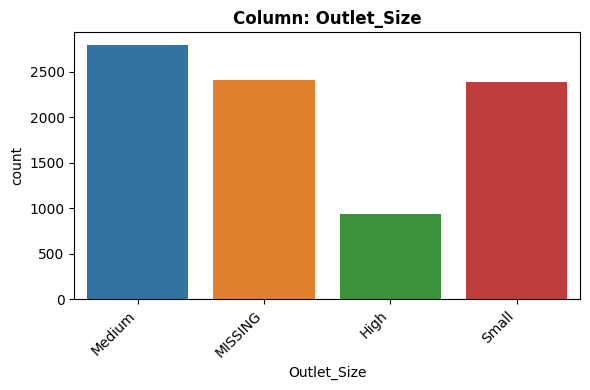

- NaN's Found: 2410 (28.28%)
- Unique Values: 4
- Most common value: 'Medium' occurs 2793 times (32.77%)
- Not constant or quasi-constant.


In [ ]:
explore_categorical(df, feature);

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)

    Categorical (nominal)

2. How many null values?

    2410

3. What percentage?

    28.28%

4. What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)

    If impute, with a place holder("Missing")

5. Is the feature constant or quasi-constant?

    Not constant or quasi-constant

6. What is the cardinality? Is it high (>10)?

    Low as a score of 5

7. Would we know this feature before the target is determined?
    Yes

8. Is there a business case/understanding reason to exclude based on our business case?
    No


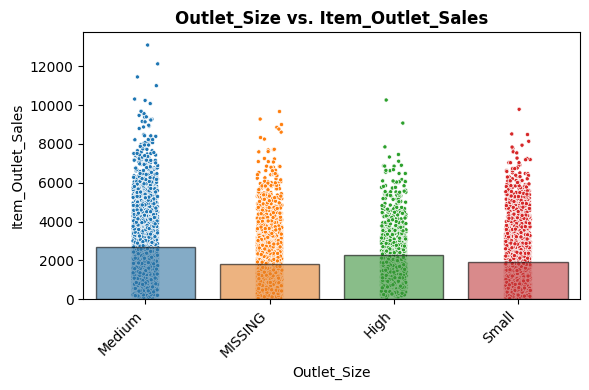

In [ ]:
# Run the appropriate feature vs. target function (based on dtype)
plot_categorical_vs_target(df, feature);

1. Based on your business understanding, would you expect this feature to be a predictor of the target?

2.  Does this feature appear to be a predictor of the target?

### Feature: Outlet_Type
**Target:** Item_Outlet_Sales

**Definition:** Whether the outlet is a grocery store or some sort of supermarket


In [ ]:
#Create a univariate visualization showing the distribution of values/categories
#define the feature
feature = "Outlet_Type"
df[feature].dtype

dtype('O')

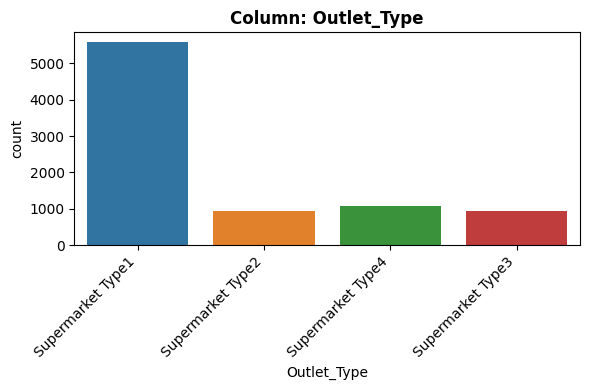

- NaN's Found: 0 (0.0%)
- Unique Values: 4
- Most common value: 'Supermarket Type1' occurs 5577 times (65.43%)
- Not constant or quasi-constant.


In [ ]:
explore_categorical(df, feature);

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)
    Categorical

2. How many null values?
    Zero

3. What percentage?
    0
4. What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)

5. Is the feature constant or quasi-constant?
    Not constant or quasi-constant
6. What is the cardinality? Is it high (>10)?
    Low(4 Unique values)
7. Would we know this feature before the target is determined?
    YEs
8. Is there a business case/understanding reason to exclude based on our business case?

    NO


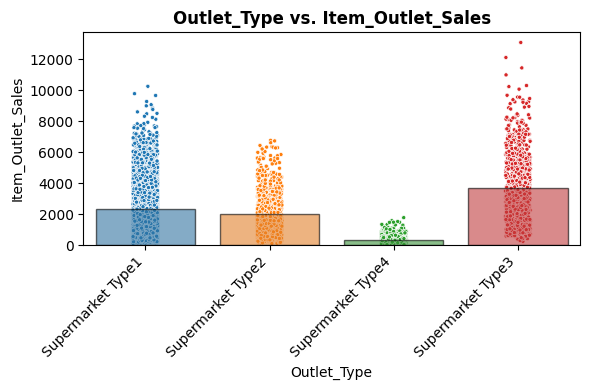

In [ ]:
# Run the appropriate feature vs. target function (based on dtype)
plot_categorical_vs_target(df, feature);

1. Based on your business understanding, would you expect this feature to be a predictor of the target?

2.  Does this feature appear to be a predictor of the target?

### Feature: Outlet_Location_Type
**Target:** Item_Outlet_Sales

**Definition:** The type of area in which the store is located


In [ ]:
#Create a univariate visualization showing the distribution of values/categories
#define the feature
feature = "Outlet_Location_Type"
df[feature].dtype

dtype('O')

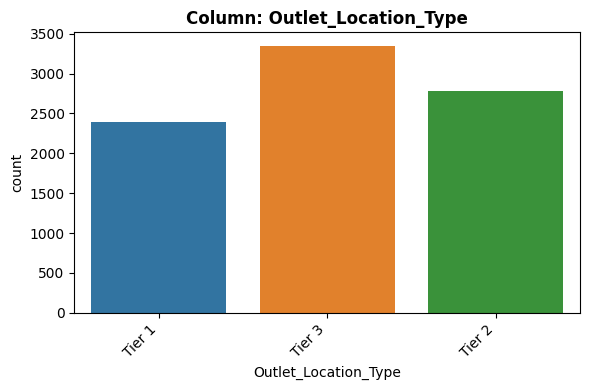

- NaN's Found: 0 (0.0%)
- Unique Values: 3
- Most common value: 'Tier 3' occurs 3350 times (39.31%)
- Not constant or quasi-constant.


In [ ]:
explore_categorical(df, feature);

1. What type of feature is it? (Categorical (nominal), ordinal, numeric)

    Categorical

2. How many null values?

    0

3. What percentage?

    N/A

4. What would you do with the null values (drop the rows? drop the column? impute? If impute, with what?)
    N/A

5. Is the feature constant or quasi-constant?
    - Not constant or quasi-constant.

6. What is the cardinality? Is it high (>10)?
    - Low it is 3
7. Would we know this feature before the target is determined?
    Yes
8. Is there a business case/understanding reason to exclude based on our business case?

    No


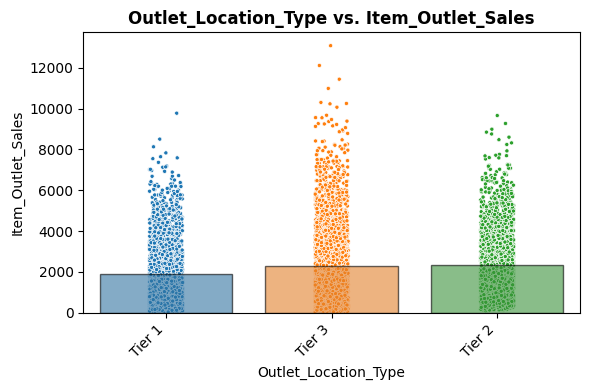

In [ ]:
# Run the appropriate feature vs. target function (based on dtype)
plot_categorical_vs_target(df, feature);

1. Based on your business understanding, would you expect this feature to be a predictor of the target?
    Yes
2.  Does this feature appear to be a predictor of the target?
    Yes, there is variability across all the categories

---
---

# Regression Models $(Week^5)$

**For Part 5, you will go back to your original, uncleaned, sales prediction dataset with the goal of preventing data leakage.**

You should load a fresh version of the original data set here using pd.read_csv() and start your cleaning process over to ensure there is no data leakage!




###Before splitting your data, you can drop duplicates and fix inconsistencies in categorical data.

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [ ]:
df2.head(6)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
5,FDP36,10.395,Regular,0.000000,Baking Goods,51.4008,OUT018,2009,Medium,Tier 3,Supermarket Type2,556.6088


In [ ]:
df2.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [ ]:
#Check for duplicated rows
df2.duplicated().sum()

0

In [ ]:
#check for missing
df2.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [ ]:
# Identify numerical features
numerical_features = []
for column in df2.columns:
  if df2[column].dtype.name != "object":
    numerical_features.append(column)

    # Identify categorical features
categorical_features = []
for column in df2.columns:
  if df2[column].dtype.name == "object":
    categorical_features.append(column)

# Print the numerical features
print("Numerical features:")
print(numerical_features)
print('\n')

# Print the categorical features
print("Categorical features:")
print(categorical_features)

In [ ]:
data_types = df.dtypes

for column, dtype in data_types.items():
    # If the data type is numeric, add the column to the numerical_features list
    if dtype in ["int64"]:
        numerical_features

    # If the data type is object, add the column to the categorical_features list
    elif dtype == "object":
        categorical_features

    # If the data type is category, add the column to the ordinal_features list
    elif dtype == "category":
        ordinal_features

print("Numerical features:", numerical_features)
print('\n')
print("Categorical features:", categorical_features)
print('\n')
print("Ordinal features:", ordinal_features)

Numerical features: ['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year', 'Item_Outlet_Sales']


Categorical features: ['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']


Ordinal features: []


In [ ]:
# Identify numerical features
numerical_features = []
for column in df.columns:
  if df[column].dtype.name != "object":
    numerical_features.append(column)

    # Identify categorical features
categorical_features = []
for column in df.columns:
  if df[column].dtype.name == "object":
    categorical_features.append(column)

# Print the numerical features
print("Numerical features:")
print(numerical_features)
print('\n')

# Print the categorical features
print("Categorical features:")
print(categorical_features)

Numerical features:
['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year', 'Item_Outlet_Sales']


Categorical features:
['Item_Fat_Content', 'Item_Type', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']


In [ ]:
#print value counts for each object column
for j in obj_columns:
  # print the value counts for the column
  print(f"{j}:")
  print(df2[j].value_counts())
  # Print an empty line for readability
  print ('\n')

Item_Type:
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


Outlet_Size:
Medium    2793
Small     2388
High       932
Name: Outlet_Size, dtype: int64


Outlet_Location_Type:
Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64


Outlet_Type:
Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64




###Fix the inconsistencies

In [ ]:
df2['Outlet_Type'] = df2['Outlet_Type'].replace('Grocery Store', 'Supermarket Type4')
df2['Outlet_Type'].value_counts()

Supermarket Type1    5577
Supermarket Type4    1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

In [ ]:
df2['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [ ]:
#change Lf to low fat and reg with regular
df2['Item_Fat_Content'] = df2['Item_Fat_Content'].replace({'LF': 'Low Fat','low fat': 'Low Fat', 'reg': 'Regular'})

In [ ]:
df2['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [ ]:
#drop coloumns, has no relation to the targert
df2 = df2.drop(['Outlet_Identifier','Item_Identifier'], axis=1)



##Identify the features (X) and target (y): Assign the "Item_Outlet_Sales" column as your target and the rest of the relevant variables as your features matrix.



###Create a preprocessing object to prepare the dataset for Machine Learning

In [ ]:
#Crate a test split
#Create Preprocessing Object
#Define X and y and train test split
y = df2['Item_Outlet_Sales']
X = df2.drop(columns='Item_Outlet_Sales')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
display(X_train.head(), y_train.head())

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
4776,16.350,Low Fat,0.029565,Household,256.4646,2009,Medium,Tier 3,Supermarket Type2
7510,15.250,Regular,0.000000,Snack Foods,179.7660,2009,Medium,Tier 3,Supermarket Type2
5828,12.350,Regular,0.158716,Meat,157.2946,1999,Medium,Tier 1,Supermarket Type1
5327,7.975,Low Fat,0.014628,Baking Goods,82.3250,2004,Small,Tier 2,Supermarket Type1
4810,19.350,Low Fat,0.016645,Frozen Foods,120.9098,2002,NaN,Tier 2,Supermarket Type1


4776     515.3292
7510    3056.0220
5828    1577.9460
5327    1331.6000
4810    1687.1372
Name: Item_Outlet_Sales, dtype: float64

###Make sure your imputation of missing values occurs after the train test split using SimpleImputer.

In [ ]:
#create a pipeline for numeric columns
num_cols = X_train.select_dtypes('number').columns

In [ ]:
mean_imputer = SimpleImputer(strategy='mean')
num_scaler = StandardScaler()
num_pipe = make_pipeline(mean_imputer, num_scaler)
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer()),
                ('standardscaler', StandardScaler())])

In [ ]:
#Create tuple
num_tuple = ('numeric', num_pipe, num_cols)
num_tuple

('numeric',
 Pipeline(steps=[('simpleimputer', SimpleImputer()),
                 ('standardscaler', StandardScaler())]),
 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
        'Outlet_Establishment_Year'],
       dtype='object'))

In [ ]:
#create pipeline for ordinal columns - impute missing values with most frequent
ord_cols = ['Outlet_Size', 'Outlet_Location_Type']

freq_imputer = SimpleImputer(strategy='most_frequent')
outlet_size_order = ['Small', 'Medium', 'High']
outlet_location_order = ['Tier 1', 'Tier 2', 'Tier 3']
ordinal_category_orders = [outlet_size_order, outlet_location_order]
ord_encoder = OrdinalEncoder(categories=ordinal_category_orders)
ord_scaler = StandardScaler()
ord_pipe = make_pipeline(freq_imputer, ord_encoder, ord_scaler)
ord_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['Small', 'Medium', 'High'],
                                            ['Tier 1', 'Tier 2', 'Tier 3']])),
                ('standardscaler', StandardScaler())])

In [ ]:
#Create tuple
ord_tuple = ('ordinal',ord_pipe, ord_cols)
ord_tuple

('ordinal',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                 ('ordinalencoder',
                  OrdinalEncoder(categories=[['Small', 'Medium', 'High'],
                                             ['Tier 1', 'Tier 2', 'Tier 3']])),
                 ('standardscaler', StandardScaler())]),
 ['Outlet_Size', 'Outlet_Location_Type'])

In [ ]:
#create pipeline for categorical columns - impute missing values with "MISSING"
cat_cols = X_train.select_dtypes('object').drop(columns=ord_cols).columns

missing_imputer = SimpleImputer(strategy='constant', fill_value='MISSING')
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
cat_pipe = make_pipeline(missing_imputer , ohe)
cat_pipe

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='MISSING', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [ ]:
#Create tuple
cat_tuple = ('categorical',cat_pipe, cat_cols)
cat_tuple

('categorical',
 Pipeline(steps=[('simpleimputer',
                  SimpleImputer(fill_value='MISSING', strategy='constant')),
                 ('onehotencoder',
                  OneHotEncoder(handle_unknown='ignore', sparse_output=False))]),
 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Type'], dtype='object'))

In [ ]:
#Use the tuples to create a ColumnTransformer
col_transformer = ColumnTransformer([num_tuple, cat_tuple], verbose_feature_names_out=False)
col_transformer

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                ('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Type'], dtype='object'))],
                  verbose_feature_names_out=False)

--------
--------

# Classifiction Models $(Week^6)$
This week, you will finalize your sales prediction project. The goal of this is to help the retailer understand the properties of products and outlets that play crucial roles in predicting sales.

Tips:
Combine your preprocessing object (from the previous step of the project) and the model into a model pipeline.
CRISP-DM Phase 4 - Modeling


## 1. Build a linear regression model to predict sales.
Build a linear regression model. Use the custom evaluation function to get the metrics for your model (on training and test data). Compare the training vs. test R-squared values and answer the question: to what extent is this model overfit/underfit?

In [ ]:
#Instantiate a linear regression model
linreg = LinearRegression()
#combine the preprocessing columns
linreg_pipe = make_pipeline(col_transformer, linreg)
linreg_pipe


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='MISSING',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Type'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('linearregression', LinearRegression())])

In [ ]:
# Fit the model on the training data
linreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='MISSING',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Type'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('linearregression', LinearRegression())])

In [ ]:
#Evaluate the model
evaluate_regression(linreg_pipe, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 847.496
- MSE = 1,300,515.557
- RMSE = 1,140.401
- R^2 = 0.561

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 805.242
- MSE = 1,197,601.243
- RMSE = 1,094.350
- R^2 = 0.566


## 2. Build a default Random Forest model.


Use the custom evaluation function to get the metrics for your model (on training and test data).

Compare the training vs. test R-squared values and answer the question: to what extent is this model overfit/underfit?

Compare this model's performance to the linear regression model: which model has the best test scores?

In [ ]:
# Instantiate default random forest model
rf = RandomForestRegressor(random_state = 42)
# Model Pipeline
rf_pipe = make_pipeline(col_transformer, rf)
rf_pipe


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='MISSING',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Type'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [ ]:
# Fit the model pipeline on the training data only
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer()),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='MISSING',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Type'], dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [ ]:
# Use custom function to evaluate default model
evaluate_regression(rf_pipe, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 300.114
- MSE = 186,782.136
- RMSE = 432.183
- R^2 = 0.937

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 780.602
- MSE = 1,268,018.285
- RMSE = 1,126.063
- R^2 = 0.540


## 3. Use GridSearchCV to tune at least two hyperparameters for a Random Forest model.

After determining the best parameters from your GridSearch, fit and evaluate a final best model on the entire training set (no folds).

Compare your tuned model to your default Random Forest: did the performance improve? CRISP-DM Phase 5 - Evaluation

In [ ]:
rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer()),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
          'Outlet_Establishment_Year'],
         dtype='object')),
                                   ('categorical',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(fill_value='MISSING',
                                                                   strategy='constant')),
                                                    ('onehotencoder',
                                                     OneHotEncoder(handle_unknown='ignore',

In [ ]:
params = {'randomforestregressor__max_depth': [10, 20, 30, 40],
          'randomforestregressor__n_estimators':[200, 250, 300, 350],
          'randomforestregressor__min_samples_leaf':[30, 60, 90, 120],
          }

In [ ]:
# Instantiate the gridsearch
gridsearch = GridSearchCV(rf_pipe, params, n_jobs=-1, verbose=1)
# Fit the gridsearch on training data
gridsearch.fit(X_train, y_train)
# Obtain best parameters
gridsearch.best_params_

Fitting 5 folds for each of 64 candidates, totalling 320 fits


{'randomforestregressor__max_depth': 10,
 'randomforestregressor__min_samples_leaf': 30,
 'randomforestregressor__n_estimators': 350}

In [ ]:
# Define and refit best model
best_rf = gridsearch.best_estimator_
evaluate_regression(best_rf, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 726.132
- MSE = 1,076,132.718
- RMSE = 1,037.368
- R^2 = 0.636

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 732.795
- MSE = 1,105,287.499
- RMSE = 1,051.327
- R^2 = 0.599


____
__________


## 4. You now have tried several different models on your data set.

You need to determine which model to implement.

Overall, which model do you recommend? Justify your recommendation.

n R-squared of 1 indicates a perfect fit, while an R-squared of 0 indicates that the model does not fit the data at all.
In a Markdown cell: Interpret your model's performance based on R-squared.

RMSE (Root Mean Square Error) is another measure of how well the regression model fits the data.
The RMSE is the average distance between the predicted values and the actual values.
A lower RMSE indicates a better fit.
MAE (Mean Absolute Error) is another measure of how well the regression model fits the data.
The MAE is the average difference between the predicted values and the actual values.
A lower MAE indicates a better fit.

Select another regression metric (RMSE/MAE/MSE) to express the performance of your model to your stakeholder.
Include why you selected this metric to explain to your stakeholder. Compare the training vs. test scores and answer the question: to what extent is this model overfit/underfit?

#Stakeholder feedback

I have evaluated the performance of the regression model and I recommend that we use the Root Mean Squared Error (RMSE) metric to express the model's performance. This is because RMSE is a more robust metric than MAE when the errors are heavily skewed. In this case, the errors are likely to be skewed, as the dependent variable is likely to be influenced by a small number of large outliers.

The RMSE of the model is 432.183. This means that, on average, the predicted values are 432.183 units away from the actual values. This is a relatively good fit, but there is still some room for improvement.

The training RMSE is 1,037.368 and the test RMSE is 1,051.327. This indicates that the model is slightly overfit to the training data. This is not a major concern, as the model is still a good fit to the data overall.



